In [6]:
pip install torch torchvision opencv-python pillow numpy pandas matplotlib seaborn scikit-learn tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import torch 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# Define transforms with data augmentation
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
])

# Simpler transform for testing (no augmentation)
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load the official Flowers-102 dataset
# Set download=True to automatically download if not present
train_dataset = datasets.Flowers102(
    root='./data',
    split='train',
    transform=transform_train,
    download=True
)

val_dataset = datasets.Flowers102(
    root='./data',
    split='val',
    transform=transform_test,
    download=True
)

test_dataset = datasets.Flowers102(
    root='./data',
    split='test',
    transform=transform_test,
    download=True
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Check dataset sizes
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
print(f"Test images: {len(test_dataset)}")

Training images: 1020
Validation images: 1020
Test images: 6149


In [2]:
# Dùng CNN 
import torch 
import torch.nn as nn
from torch.nn import Module, Linear, Conv2d, MaxPool2d, ReLU
from torch import flatten

# Linear: Fully Connected Layer, biến đổi feature map(đặc trưng) thành vector đầu vào cho classifier
# Maxpool2d: giảm số chiều không gian của đầu vào(feature map) nhưng vẫn giữ thông tin quan trọng
# flatten: giảm chiều của đầu ra (Convo, Maxpool) để cho FC sau đó

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        
        # Set đầu tiên: Conv -> ReLu -> Maxpool
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1) # 16 feature map
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # stride = 2 => giảm kích thước 2 lần, pool để giảm kích thước NHƯNG vẫn giữ lại info qtrong
        
        # Set thứ hai: Conv -> Relu -> Maxpool
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # stride = 2 => giảm kích thước 2 lần 
        
        # Fully connected layer
        self.fc1 = nn.Linear(32 * 56 * 56, 512)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(256, num_classes)
        
    def forward(self, x): # input: x
        # pass qua set 1
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.max_pool1(x)
        # pass qua set 2
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.max_pool2(x)
        # pass qua FC, can phai flatten sang 1D de Linear
        x = flatten(x, 1) # hoac la x.view(x.size(0), -1), [batchsize, featuremap]
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        # cho x qua softmax de predict xac suat moi lop 
        # output = self.softmax(x), khong can softmax vì trong CrossEntropyLoss đã có softmax rồi
        return x
        

In [3]:
# khởi tạo tham số, model
import torch.optim as optim
lr = 0.001
epochs = 200
num_classes = 102

model = CNN(num_classes)
criterion = nn.CrossEntropyLoss() # loss
optimizer = optim.Adam(model.parameters(), lr=lr) # dung Adam 

In [4]:
# Training

train_loss = []
train_accuracy = []
for ep in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0 # so du doan dung
    total = 0
    
    for inputs, labels in train_loader:
        # xoa gradient
        optimizer.zero_grad()
        
        # forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # backpropagation

        loss.backward()
        optimizer.step()
        
        # Tinh loss, acc
        running_loss += loss.item() # tinh tong loss qua 1 ep
        _, predicted = torch.max(outputs, 1) # lay ra du doan(cai xac suat lon nhat)
        total += labels.size(0) # lay so luong mau trong batch, cong qua tung batch
        correct += (predicted == labels).sum().item() # so du doan dung
        
    train_loss.append(running_loss / len(train_loader)) # them loss cua 1 ep vao list
    train_accuracy.append(correct/total * 100) # them accuracy 1 ep vao list
    print(f"Epoch {ep + 1}, Loss: {running_loss / len(train_loader):.4f}, Accuracy: {100 * correct/total :.2f}%")

Epoch 1, Loss: 4.6743, Accuracy: 0.69%
Epoch 2, Loss: 4.6277, Accuracy: 0.78%
Epoch 3, Loss: 4.6276, Accuracy: 0.59%
Epoch 4, Loss: 4.6271, Accuracy: 0.49%
Epoch 5, Loss: 4.6292, Accuracy: 0.69%
Epoch 6, Loss: 4.6201, Accuracy: 0.59%
Epoch 7, Loss: 4.5918, Accuracy: 1.67%
Epoch 8, Loss: 4.4908, Accuracy: 1.67%
Epoch 9, Loss: 4.3052, Accuracy: 3.04%
Epoch 10, Loss: 4.1285, Accuracy: 4.22%
Epoch 11, Loss: 3.9803, Accuracy: 4.61%
Epoch 12, Loss: 3.8755, Accuracy: 8.14%
Epoch 13, Loss: 3.8227, Accuracy: 6.57%
Epoch 14, Loss: 3.7062, Accuracy: 7.75%
Epoch 15, Loss: 3.7204, Accuracy: 7.75%
Epoch 16, Loss: 3.6301, Accuracy: 10.98%
Epoch 17, Loss: 3.5579, Accuracy: 9.61%
Epoch 18, Loss: 3.4895, Accuracy: 12.55%
Epoch 19, Loss: 3.4898, Accuracy: 12.84%
Epoch 20, Loss: 3.3918, Accuracy: 12.16%
Epoch 21, Loss: 3.3418, Accuracy: 15.59%
Epoch 22, Loss: 3.3118, Accuracy: 15.39%
Epoch 23, Loss: 3.2559, Accuracy: 15.59%
Epoch 24, Loss: 3.1646, Accuracy: 18.24%
Epoch 25, Loss: 3.1621, Accuracy: 16.96%


In [7]:
# Test
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1) # lay nhan predict
        correct += (predicted == labels).sum().item() # lay so du doan dung
        total += labels.size(0) # lay tong so mau trong batch moi lan lay batch
    print(f"Accuracy test: {100 * correct/total :.2f}%")

Accuracy test: 29.70%


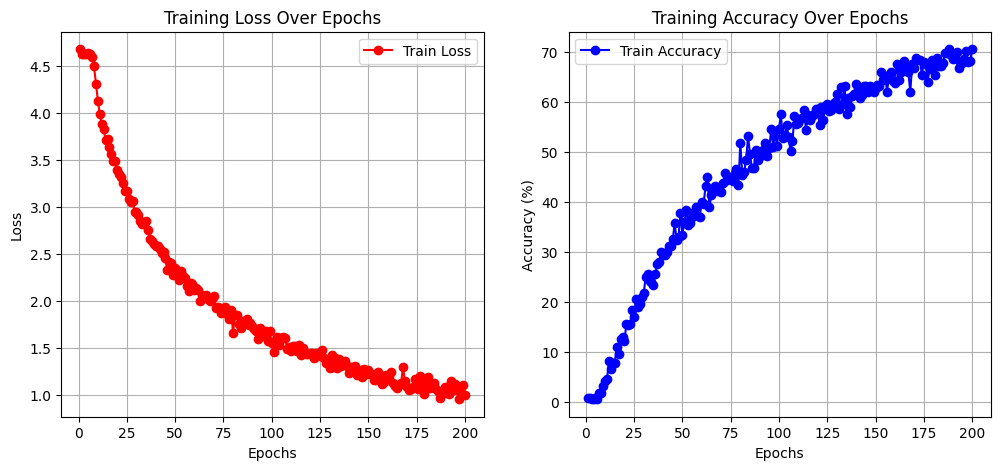

In [10]:
import matplotlib.pyplot as plt

# Vẽ Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, marker='o', linestyle='-', color='r', label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()

# Vẽ Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, marker='o', linestyle='-', color='b', label="Train Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy Over Epochs")
plt.legend()
plt.grid()

plt.show()